In [1]:
# Import libraries

import sys
import re
import requests
import json
import asyncio
import nest_asyncio
import aiohttp
import time
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Suppress unnecessary Shapely warning
warnings.filterwarnings('ignore',
                        '.*Shapely GEOS version.*')

from aiohttp import ClientSession
from requests import request, Session
from itertools import product, repeat
import os
from dotenv import load_dotenv
from os import getenv
from threading import Thread
import time
import inspect
import pandas as pd
import geopandas as gp
import shapely
import pygeos
import contextily as cx
from functools import reduce
from pandas.plotting import lag_plot
import pickle
import numpy as np
import seaborn as sns
import datetime as dt
import copy
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from multiprocess import Process, Pool

from sklearn.linear_model import LinearRegression, Ridge

# Set up Pandas defaults
pd.options.display.float_format = '{:.6f}'.format
pd.set_option("display.max_columns", None)



### Define Helper Datasets

In [2]:
# Define helper function to create directory
def create_folder(the_path):
    if not os.path.isdir(the_path):
        os.mkdir(the_path)

# Turn into datetime format for monthly datasets
def turn_df_into_datetime_monthly(dataframe, 
                          columns_as_index: list):
    """
    Turns a dataframe created by the API functions
    into a tidy datetime format.
    """
    # Make a copy
    df = dataframe.copy()
    
    # Set index
    df = df.set_index(columns_as_index)
    
    # Stack
    df = df.stack()
    
    # Turn into dataframe
    df = pd.DataFrame(df).reset_index()
    
    # Get level number
    level_num = len(columns_as_index)
    
    # Rename the post-stacked columns
    df.rename(columns={f'level_{level_num}':'year', 0:'value'}, inplace=True)
        
    # Make date column datetime
    df['year'] = pd.to_datetime(df['year'])
    
    # Make it beginning of month
    df['year'] = df['year'].astype("datetime64[M]")
    
    return df


In [3]:
# Read in Zillow city datasets
def read_zillow_datasets(
    path, 
    read_city=False, 
    read_zip_code=False,
    columns_as_index=['RegionName','Metro']
):
    
    # Read in dataset
    city = pd.read_csv(path, dtype={'RegionName':str})
        
    if read_city:
        # Combine city name and state
        city['RegionName'] = city['RegionName'] + ', ' + city['State']
    elif read_zip_code:
        city['City'] = city['City'] + ', ' + city['State']

    # Only keep necessary columns
    city.drop(
        columns=['RegionID','State','SizeRank','RegionType','StateName','CountyName'], 
        inplace=True)

    # Drop 'duplicates' (which are really just smaller cities in different counties)
    city = city.drop_duplicates(keep='first').reset_index(drop=True)
    
    # Turn data tidy
    city = turn_df_into_datetime_monthly(
        city, 
        columns_as_index=columns_as_index)
    
    # Start the dataset at 2016
#     city = city[
#         city['year'] >= pd.to_datetime('2016-01-01')].reset_index(drop=True)
    
    return city
    
    

In [4]:
zip_rent = read_zillow_datasets(
    path='datasets/zillow/zillow_rental/Zip_zori_sm_month.csv',
    read_city=False, 
    read_zip_code=True,
    columns_as_index=['RegionName','City','Metro']
)

zip_rent

,RegionName,City,Metro,year,value
0,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2015-03-01,1561.065329
1,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2015-04-01,1562.369406
2,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2015-05-01,1574.918814
3,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2015-06-01,1583.582127
4,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2015-07-01,1591.720185
...,...,...,...,...,...
241812,89158,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",2023-02-01,3800.443474
241813,89158,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",2023-03-01,3836.115656
241814,89158,"Las Vegas, NV","Las Vegas-Henderson-Paradise, NV",2023-04-01,3741.083333
241815,12085,"Guilderland Center, NY","Albany-Schenectady-Troy, NY",2023-03-01,1192.094145


In [5]:
zip_price = read_zillow_datasets(
    path='datasets/zillow/zillow_median_price/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv',
    read_city=False, 
    read_zip_code=True,
    columns_as_index=['RegionName','City','Metro']
)

zip_price

,RegionName,City,Metro,year,value
0,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2000-01-01,152741.646117
1,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2000-02-01,153409.652418
2,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2000-03-01,153890.200746
3,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2000-04-01,155221.436816
4,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2000-05-01,156618.956433
...,...,...,...,...,...
5462700,50160,"Martensdale, IA","Des Moines-West Des Moines, IA",2022-12-01,188827.849057
5462701,50160,"Martensdale, IA","Des Moines-West Des Moines, IA",2023-01-01,188730.491540
5462702,50160,"Martensdale, IA","Des Moines-West Des Moines, IA",2023-02-01,188683.774120
5462703,50160,"Martensdale, IA","Des Moines-West Des Moines, IA",2023-03-01,189253.674092


In [6]:
# Read in most recent job data
jobs = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

# Make sure the date column is in datetime format
jobs['date'] = pd.to_datetime(jobs['date'])

# Replace NECTA Division
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

jobs

,msa_code,msa_name,state_code,year,month,date,value,series_id
0,10180,"Abilene, TX",48,2023,June,2023-06-01,76400.000000,SMS48101800000000001
1,10180,"Abilene, TX",48,2023,May,2023-05-01,76300.000000,SMS48101800000000001
2,10180,"Abilene, TX",48,2023,April,2023-04-01,76100.000000,SMS48101800000000001
3,10180,"Abilene, TX",48,2023,March,2023-03-01,76100.000000,SMS48101800000000001
4,10180,"Abilene, TX",48,2023,February,2023-02-01,76000.000000,SMS48101800000000001
...,...,...,...,...,...,...,...,...
44455,49740,"Yuma, AZ",04,2014,May,2014-05-01,52200.000000,SMS04497400000000001
44456,49740,"Yuma, AZ",04,2014,April,2014-04-01,52100.000000,SMS04497400000000001
44457,49740,"Yuma, AZ",04,2014,March,2014-03-01,51700.000000,SMS04497400000000001
44458,49740,"Yuma, AZ",04,2014,February,2014-02-01,51500.000000,SMS04497400000000001


In [12]:
Denison_jobs = jobs[jobs['msa_name'].str.contains('Sherman-Denison')].copy()
Atlanta_jobs = jobs[jobs['msa_name'].str.contains('Atlanta')].copy()
Fayetteville_jobs = jobs[jobs['msa_name'].str.contains('Fayetteville-Springdale-Rogers, AR')].copy()


In [13]:
Denison_jobs
Atlanta_jobs
Fayetteville_jobs

,msa_code,msa_name,state_code,year,month,date,value,series_id
13680,22220,"Fayetteville-Springdale-Rogers, AR",05,2023,June,2023-06-01,306300.000000,SMS05222200000000001
13681,22220,"Fayetteville-Springdale-Rogers, AR",05,2023,May,2023-05-01,306900.000000,SMS05222200000000001
13682,22220,"Fayetteville-Springdale-Rogers, AR",05,2023,April,2023-04-01,306600.000000,SMS05222200000000001
13683,22220,"Fayetteville-Springdale-Rogers, AR",05,2023,March,2023-03-01,305700.000000,SMS05222200000000001
13684,22220,"Fayetteville-Springdale-Rogers, AR",05,2023,February,2023-02-01,304600.000000,SMS05222200000000001
...,...,...,...,...,...,...,...,...
13789,22220,"Fayetteville-Springdale-Rogers, AR",05,2014,May,2014-05-01,224500.000000,SMS05222200000000001
13790,22220,"Fayetteville-Springdale-Rogers, AR",05,2014,April,2014-04-01,223100.000000,SMS05222200000000001
13791,22220,"Fayetteville-Springdale-Rogers, AR",05,2014,March,2014-03-01,222100.000000,SMS05222200000000001
13792,22220,"Fayetteville-Springdale-Rogers, AR",05,2014,February,2014-02-01,221100.000000,SMS05222200000000001


In [21]:
zip_rent[zip_rent['Metro']=='Fayetteville-Springdale-Rogers, AR'].head(1)

,RegionName,City,Metro,year,value
62370,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2018-11-01,996.035866


In [31]:
zip_price[zip_price['Metro']=='Fayetteville-Springdale-Rogers, AR']['City'].drop_duplicates()

185022          Springdale, AR
285180        Fayetteville, AR
409934              Rogers, AR
418957         Bentonville, AR
1433900     Siloam Springs, AR
1955022             Lowell, AR
1998873        Bella Vista, AR
2310138          Centerton, AR
2402569      Prairie Grove, AR
2512467         Huntsville, AR
2564416             Gentry, AR
2710098         Farmington, AR
2845946           Gravette, AR
2904672          Pea Ridge, AR
3058904          West Fork, AR
3078970             Elkins, AR
3187160           Garfield, AR
3214401       Cave Springs, AR
3427617            Lincoln, AR
3576473            Winslow, AR
3891702            Decatur, AR
4443842    Sulphur Springs, AR
4886906             Wesley, AR
Name: City, dtype: object

In [28]:
zip_rent[zip_rent['City']=='Fayetteville, AR']

,RegionName,City,Metro,year,value
62370,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2018-11-01,996.035866
62371,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2018-12-01,1004.057048
62372,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-01-01,1028.563469
62373,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-02-01,1012.764400
62374,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-03-01,1003.213329
...,...,...,...,...,...
152212,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2022-12-01,1721.688906
152213,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-01-01,1748.552170
152214,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-02-01,1728.999175
152215,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-03-01,1723.896729


In [26]:
zip_rent[
    (zip_rent['Metro']=='Fayetteville-Springdale-Rogers, AR')
][[
    'RegionName','City','Metro'
]].drop_duplicates()

,RegionName,City,Metro
62370,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR"
80202,72762,"Springdale, AR","Fayetteville-Springdale-Rogers, AR"
85162,72758,"Rogers, AR","Fayetteville-Springdale-Rogers, AR"
86746,72712,"Bentonville, AR","Fayetteville-Springdale-Rogers, AR"
92369,72756,"Rogers, AR","Fayetteville-Springdale-Rogers, AR"
145238,72703,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR"
152142,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR"
196590,72713,"Bentonville, AR","Fayetteville-Springdale-Rogers, AR"
200678,72761,"Siloam Springs, AR","Fayetteville-Springdale-Rogers, AR"
225801,72715,"Bella Vista, AR","Fayetteville-Springdale-Rogers, AR"


In [32]:
Denison_zip_rent = zip_rent[zip_rent['RegionName']=='75020'].copy()
Fairburn_zip_rent = zip_rent[zip_rent['RegionName']=='30213'].copy()
Mcdonough_zip_rent = zip_rent[zip_rent['RegionName']=='30253'].copy()
Fayetteville_zip_rent = zip_rent[zip_rent['City']=='Fayetteville, AR'].copy()

Denison_zip_price = zip_price[zip_price['RegionName']=='75020'].copy()
Fairburn_zip_price = zip_price[zip_price['RegionName']=='30213'].copy()
Mcdonough_zip_price = zip_price[zip_price['RegionName']=='30253'].copy()
Fayetteville_zip_price = zip_price[zip_price['City']=='Fayetteville, AR'].copy()



In [34]:
Fayetteville_zip_rent

,RegionName,City,Metro,year,value
62370,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2018-11-01,996.035866
62371,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2018-12-01,1004.057048
62372,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-01-01,1028.563469
62373,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-02-01,1012.764400
62374,72701,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2019-03-01,1003.213329
...,...,...,...,...,...
152212,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2022-12-01,1721.688906
152213,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-01-01,1748.552170
152214,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-02-01,1728.999175
152215,72704,"Fayetteville, AR","Fayetteville-Springdale-Rogers, AR",2023-03-01,1723.896729


<AxesSubplot:xlabel='date'>

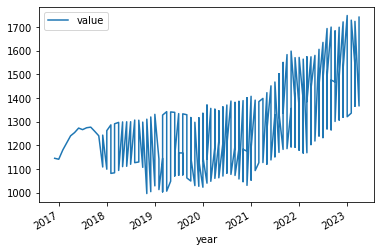

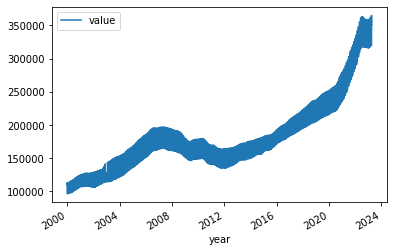

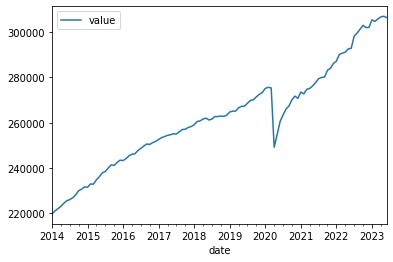

In [33]:
Fayetteville_zip_rent.plot(x='year', y='value')
Fayetteville_zip_price.plot(x='year', y='value')
Fayetteville_jobs.plot(x='date', y='value')

<AxesSubplot:xlabel='date'>

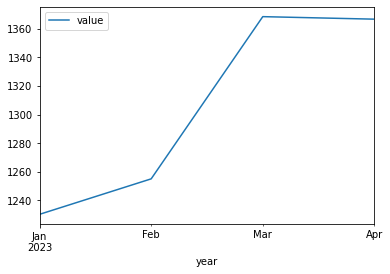

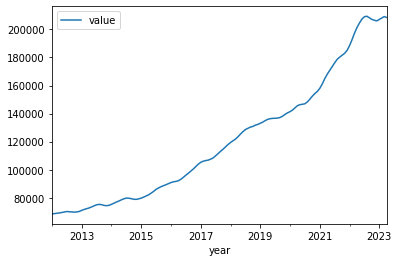

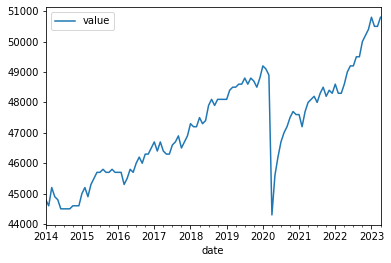

In [139]:
Denison_zip_rent.plot(x='year', y='value')
Denison_zip_price.plot(x='year', y='value')
Denison_jobs.plot(x='date', y='value')


<AxesSubplot:xlabel='date'>

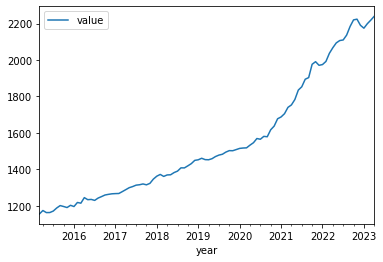

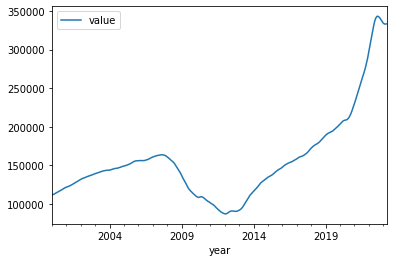

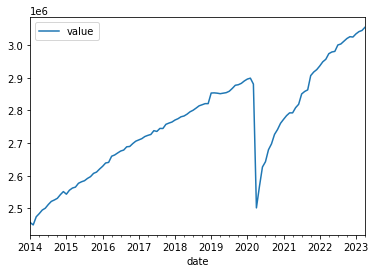

In [140]:
Fairburn_zip_rent.plot(x='year', y='value')
Fairburn_zip_price.plot(x='year', y='value')
Atlanta_jobs.plot(x='date', y='value')


<AxesSubplot:xlabel='year'>

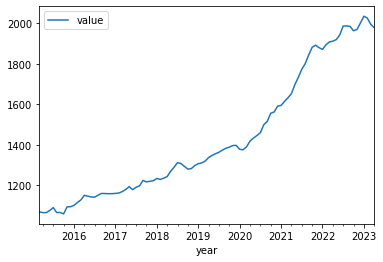

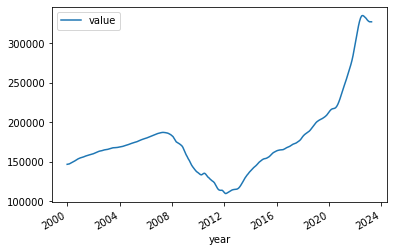

In [134]:
Mcdonough_zip_rent.plot(x='year', y='value')
Mcdonough_zip_price.plot(x='year', y='value')


In [35]:
# Read in City Price
city_price = read_zillow_datasets(
    path='datasets/zillow/zillow_median_price/City_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv',
    read_city=True
)

city_price

,RegionName,Metro,year,value
0,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2000-01-01,185694.156196
1,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2000-02-01,186696.069183
2,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2000-03-01,187732.588147
3,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2000-04-01,189671.881302
4,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2000-05-01,191581.476931
...,...,...,...,...
4135735,"Martin City, MT","Kalispell, MT",2022-12-01,513900.572373
4135736,"Martin City, MT","Kalispell, MT",2023-01-01,509506.609853
4135737,"Martin City, MT","Kalispell, MT",2023-02-01,506054.707268
4135738,"Martin City, MT","Kalispell, MT",2023-03-01,503665.265709


In [36]:
# Read in City Rent
city_rent = read_zillow_datasets(
    path='datasets/zillow/zillow_rental/City_zori_sm_month.csv',
    read_city=True
)

city_rent

,RegionName,Metro,year,value
0,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2015-03-01,2713.600040
1,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2015-04-01,2739.385877
2,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2015-05-01,2762.869638
3,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2015-06-01,2785.525096
4,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2015-07-01,2800.160007
...,...,...,...,...
117319,"Amagansett, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-02-01,29638.622467
117320,"Amagansett, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-03-01,39705.419197
117321,"Amagansett, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,39703.444444
117322,"Guilderland Center, NY","Albany-Schenectady-Troy, NY",2023-03-01,1192.094145


In [37]:
latest_rent = city_rent.drop_duplicates(
    'RegionName', keep='last').reset_index(
    drop=True).copy().rename(columns={'value':'rent'})

latest_price = city_price.drop_duplicates(
    'RegionName', keep='last').reset_index(
    drop=True).copy().rename(columns={'value':'price'})


latest_zip_rent = zip_rent.drop_duplicates(
    'RegionName', keep='last').reset_index(
    drop=True).copy().rename(columns={'value':'rent'})

latest_zip_price = zip_price.drop_duplicates(
    'RegionName', keep='last').reset_index(
    drop=True).copy().rename(columns={'value':'price'})

latest_rent
latest_price

,RegionName,Metro,year,price
0,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,714519.607828
1,"Los Angeles, CA","Los Angeles-Long Beach-Anaheim, CA",2023-04-01,960945.634493
2,"Houston, TX","Houston-The Woodlands-Sugar Land, TX",2023-04-01,267899.061021
3,"Chicago, IL","Chicago-Naperville-Elgin, IL-IN-WI",2023-04-01,289077.291205
4,"San Antonio, TX","San Antonio-New Braunfels, TX",2023-04-01,264535.167803
...,...,...,...,...
22199,"Jumpertown, MS","Tupelo, MS",2023-04-01,110757.612495
22200,"Dollar Bay, MI","Houghton, MI",2023-04-01,122398.808870
22201,"Fort Howard, MD","Baltimore-Columbia-Towson, MD",2023-04-01,293198.666093
22202,"Hoisington, KS","Great Bend, KS",2023-04-01,74356.702548


In [38]:
latest_zip_rent
latest_zip_price

,RegionName,City,Metro,year,price
0,08701,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,657754.828835
1,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2023-04-01,483829.146087
2,77449,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2023-04-01,276593.201958
3,11368,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,850601.701855
4,78660,"Pflugerville, TX","Austin-Round Rock-Georgetown, TX",2023-04-01,423028.220043
...,...,...,...,...,...
26908,22731,"Madison, VA","Washington-Arlington-Alexandria, DC-VA-MD-WV",2023-04-01,339262.350026
26909,52163,"Protivin, IA",NaN,2023-04-01,107394.020424
26910,26576,"Farmington, WV","Fairmont, WV",2023-04-01,104808.801989
26911,16245,"Oak Ridge, PA","Pittsburgh, PA",2023-04-01,81342.133746


In [39]:
# Merge them
city_rp = latest_rent.merge(latest_price, 
                            how='inner',
                            on=['RegionName','Metro','year']
                           )

city_rp['rp_ratio'] = city_rp['rent']/city_rp['price']


zip_rp = latest_zip_rent.merge(latest_zip_price, 
                            how='inner',
                            on=['RegionName','City','Metro','year']
                           )

zip_rp['rp_ratio'] = zip_rp['rent']/zip_rp['price']


city_rp
zip_rp

,RegionName,City,Metro,year,rent,price,rp_ratio
0,77494,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2023-04-01,1933.289664,483829.146087,0.003996
1,77449,"Katy, TX","Houston-The Woodlands-Sugar Land, TX",2023-04-01,1776.110784,276593.201958,0.006421
2,78660,"Pflugerville, TX","Austin-Round Rock-Georgetown, TX",2023-04-01,1900.793839,423028.220043,0.004493
3,11385,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,2767.198257,767544.628057,0.003605
4,79936,"El Paso, TX","El Paso, TX",2023-04-01,1398.711538,201742.328664,0.006933
...,...,...,...,...,...,...,...
6276,11932,"Bridgehampton, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,64583.000000,3311888.216788,0.019500
6277,15142,"Presto, PA","Pittsburgh, PA",2023-04-01,1589.000000,632116.296450,0.002514
6278,46048,"Ingalls, IN","Indianapolis-Carmel-Anderson, IN",2023-04-01,1742.000000,192371.836831,0.009055
6279,11930,"Amagansett, NY","New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,39703.444444,3169197.658144,0.012528


In [47]:
city_rp[city_rp['Metro'].fillna('').str.contains(', AR')].sort_values(
    'rp_ratio', ascending=False)

,RegionName,Metro,year,rent,price,rp_ratio
1397,"Jacksonville, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1074.500000,139686.878492,0.007692
1139,"Benton, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1449.930556,208093.496456,0.006968
2400,"Bryant, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1573.750000,230222.895200,0.006836
1626,"Sherwood, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1381.750000,205142.411776,0.006736
733,"North Little Rock, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,927.382479,139684.545697,0.006639
1628,"Van Buren, AR","Fort Smith, AR-OK",2023-04-01,1115.000000,171254.287466,0.006511
512,"Fort Smith, AR","Fort Smith, AR-OK",2023-04-01,1033.231481,160423.302326,0.006441
1493,"Cabot, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1405.333333,218759.631661,0.006424
561,"Jonesboro, AR","Jonesboro, AR",2023-04-01,1256.944444,207338.992041,0.006062
609,"Conway, AR","Little Rock-North Little Rock-Conway, AR",2023-04-01,1327.037037,221628.053373,0.005988


In [42]:
# EDA
city_eda = city_rp.copy()

city_eda = city_eda[
    (city_eda['price']<270_000)
    & (city_eda['rent']>1100)]

city_eda = city_eda[~city_eda['Metro'].str.contains(
    'Chicago-Naperville-Elgin, IL-IN-WI|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD')]

city_eda = city_eda[~city_eda['Metro'].str.contains(
    'Memphis, TN-MS-AR|Houston-The Woodlands-Sugar Land, TX|St. Louis, MO-IL')]

city_eda = city_eda[~city_eda['RegionName'].str.contains(
    ', PA|, NY|, OH|, LA|, MI|, NJ|, MD|, AL|, IL|, GA')]


city_eda.sort_values('rp_ratio', ascending=False).head(50)
city_eda.sort_values('rent', ascending=False).head(50)



,RegionName,Metro,year,rent,price,rp_ratio
2984,"Ranlo, NC","Charlotte-Concord-Gastonia, NC-SC",2023-04-01,2201.250000,264701.651055,0.008316
364,"Lehigh Acres, FL","Cape Coral-Fort Myers, FL",2023-04-01,2114.204906,258930.961015,0.008165
2239,"Dade City, FL","Tampa-St. Petersburg-Clearwater, FL",2023-04-01,1983.611111,244081.892304,0.008127
1757,"Ocean Springs, MS","Gulfport-Biloxi, MS",2023-04-01,1949.388889,248195.598981,0.007854
2546,"Gibsonville, NC","Greensboro-High Point, NC",2023-04-01,1852.500000,268396.421694,0.006902
2785,"Rural Hall, NC","Winston-Salem, NC",2023-04-01,1840.000000,252742.199991,0.007280
2697,"California City, CA","Bakersfield, CA",2023-04-01,1790.666667,265053.096935,0.006756
2845,"Saint Francis, WI","Milwaukee-Waukesha, WI",2023-04-01,1778.666667,226349.972266,0.007858
2148,"Belton, MO","Kansas City, MO-KS",2023-04-01,1766.435185,233851.145463,0.007554
1145,"Port Richey, FL","Tampa-St. Petersburg-Clearwater, FL",2023-04-01,1765.558442,236302.471188,0.007472


In [214]:
# EDA
city_eda = zip_rp.copy()

city_eda = city_eda[
    (city_eda['price']<220_000)
    & (city_eda['rent']>1600)
]

city_eda = city_eda[~city_eda['Metro'].str.contains(
    'Chicago-Naperville-Elgin, IL-IN-WI|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD')]

city_eda = city_eda[~city_eda['Metro'].str.contains(
    'Memphis, TN-MS-AR|Houston-The Woodlands-Sugar Land, TX|St. Louis, MO-IL|Dallas-Fort Worth-Arlington, TX')]

city_eda = city_eda[~city_eda['Metro'].str.contains(
    'San Antonio-New Braunfels, TX')]

city_eda = city_eda[~city_eda['City'].str.contains(
    ', PA|, NY|, OH|, LA|, MI|, NJ|, MD|, AL|, IL')]


city_eda.sort_values('rp_ratio', ascending=False).head(50)

,RegionName,City,Metro,year,rent,price,rp_ratio
4917,33974,"Lehigh Acres, FL","Cape Coral-Fort Myers, FL",2023-04-01,2147.000000,114712.962024,0.018716
3246,79701,"Midland, TX","Midland, TX",2023-04-01,1900.000000,177188.887315,0.010723
5369,75601,"Longview, TX","Longview, TX",2023-04-01,2000.000000,196813.748399,0.010162
5945,55454,"Minneapolis, MN","Minneapolis-St. Paul-Bloomington, MN-WI",2023-04-01,1634.444444,161720.368836,0.010107
2988,29611,"Greenville, SC","Greenville-Anderson, SC",2023-04-01,1768.544012,175846.235356,0.010057
5357,06519,"New Haven, CT","New Haven-Milford, CT",2023-04-01,2169.250000,216889.606856,0.010002
5437,40213,"Louisville, KY","Louisville/Jefferson County, KY-IN",2023-04-01,1758.750000,180751.819064,0.009730
3454,29303,"Spartanburg, SC","Spartanburg, SC",2023-04-01,1647.500000,171378.023896,0.009613
6278,46048,"Ingalls, IN","Indianapolis-Carmel-Anderson, IN",2023-04-01,1742.000000,192371.836831,0.009055
5724,37404,"Chattanooga, TN","Chattanooga, TN-GA",2023-04-01,1642.083333,195825.757166,0.008385


<AxesSubplot:xlabel='date'>

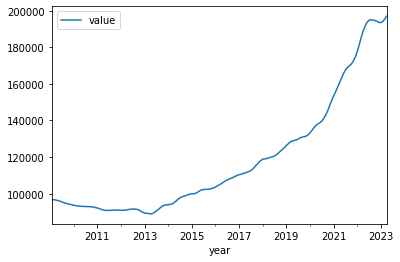

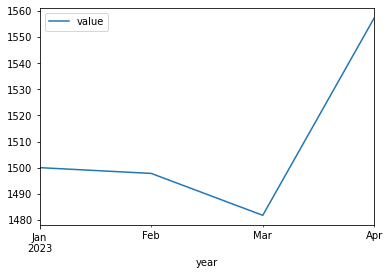

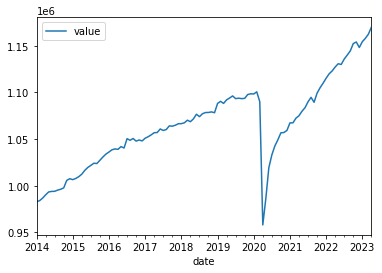

In [183]:
city_price[city_price['RegionName']=='Shelbyville, IN'].plot(x='year',y='value')
city_rent[city_rent['RegionName']=='Shelbyville, IN'].plot(x='year',y='value')
jobs[jobs['msa_name']=='Indianapolis-Carmel-Anderson, IN'].plot(x='date',y='value')

In [163]:
city_rent[city_rent['RegionName']=='Markham, IL']

,RegionName,Metro,year,value
114778,"Markham, IL","Chicago-Naperville-Elgin, IL-IN-WI",2023-04-01,2066.666667


In [146]:
latest_rent

,RegionName,Metro,year,value
0,New York,"New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,3499.709476
1,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",2023-04-01,2902.220962
2,Houston,"Houston-The Woodlands-Sugar Land, TX",2023-04-01,1616.965076
3,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",2023-04-01,2055.115381
4,San Antonio,"San Antonio-New Braunfels, TX",2023-04-01,1472.290149
...,...,...,...,...
2640,Pendergrass,"Jefferson, GA",2023-04-01,2080.000000
2641,Lake Hart,"Orlando-Kissimmee-Sanford, FL",2023-04-01,2235.000000
2642,Tonka Bay,"Minneapolis-St. Paul-Bloomington, MN-WI",2023-04-01,2840.333333
2643,Amagansett,"New York-Newark-Jersey City, NY-NJ-PA",2023-04-01,39703.444444


In [52]:
city_rent['RegionName'].value_counts()

Morrisville, NC          98
Merced, CA               98
Fort Walton Beach, FL    98
Bothell, WA              98
Palm Desert, CA          98
                         ..
Greensboro, GA            1
Keizer, OR                1
Whitefish Bay, WI         1
Sorrento, FL              1
New Market, MD            1
Name: RegionName, Length: 3058, dtype: int64